In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Importing necessary libraries

In [2]:
pip install tensorflow-addons

In [3]:
!pip install visualkeras
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *

## Setting up general parameters

In [5]:
# General parameters
epochs = 15
pic_size = 240
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


## Data Loading, Preperation and Visualization

In [7]:
folder_path = "/content/drive/MyDrive/7thsemproject/archive3"
no_images = os.listdir(folder_path + '/no/')
yes_images = os.listdir(folder_path + '/yes/')
dataset=[]
lab=[]

for image_name in no_images:
    image=cv2.imread(folder_path + '/no/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

for image_name in yes_images:
    image=cv2.imread(folder_path + '/yes/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [8]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(253, 240, 240, 3) (253,)


In [9]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=42)

In [10]:
def plot_state(state):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path + "/" + state + "/" + os.listdir(folder_path + "/" + state)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)
    plt.show()

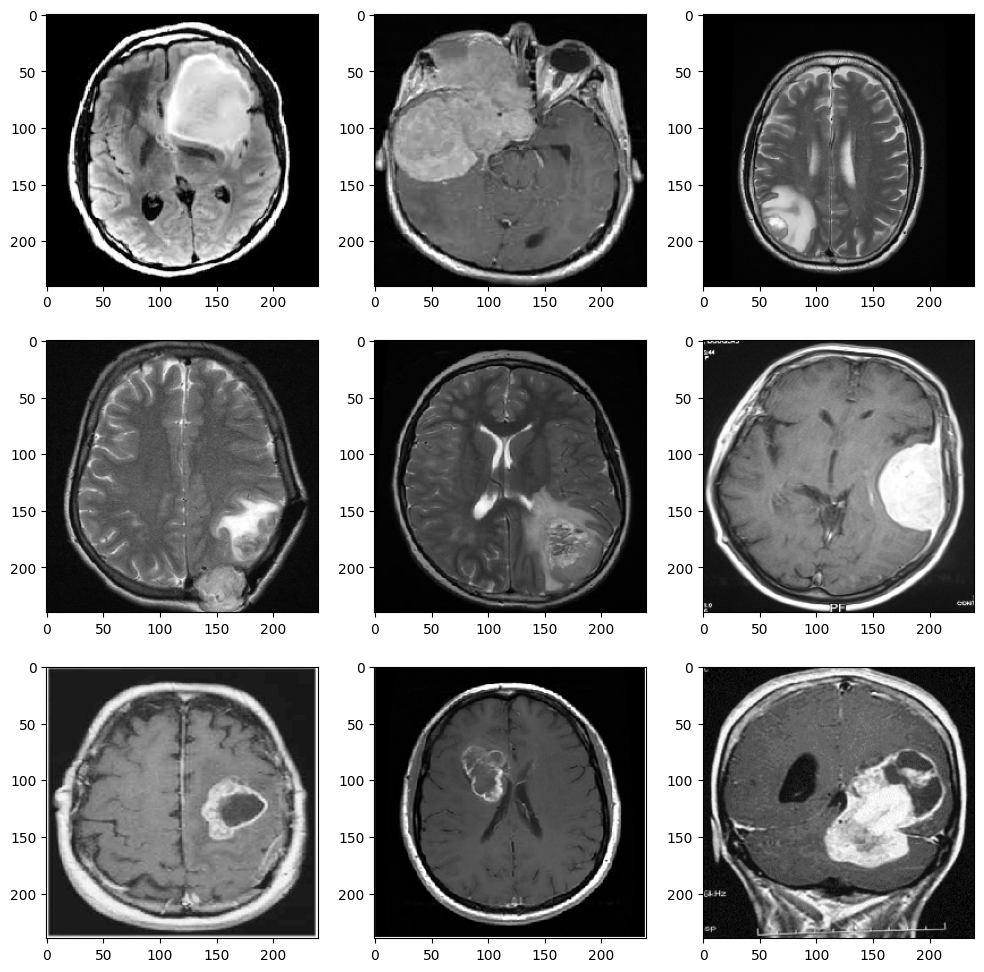

In [11]:
plot_state('yes')

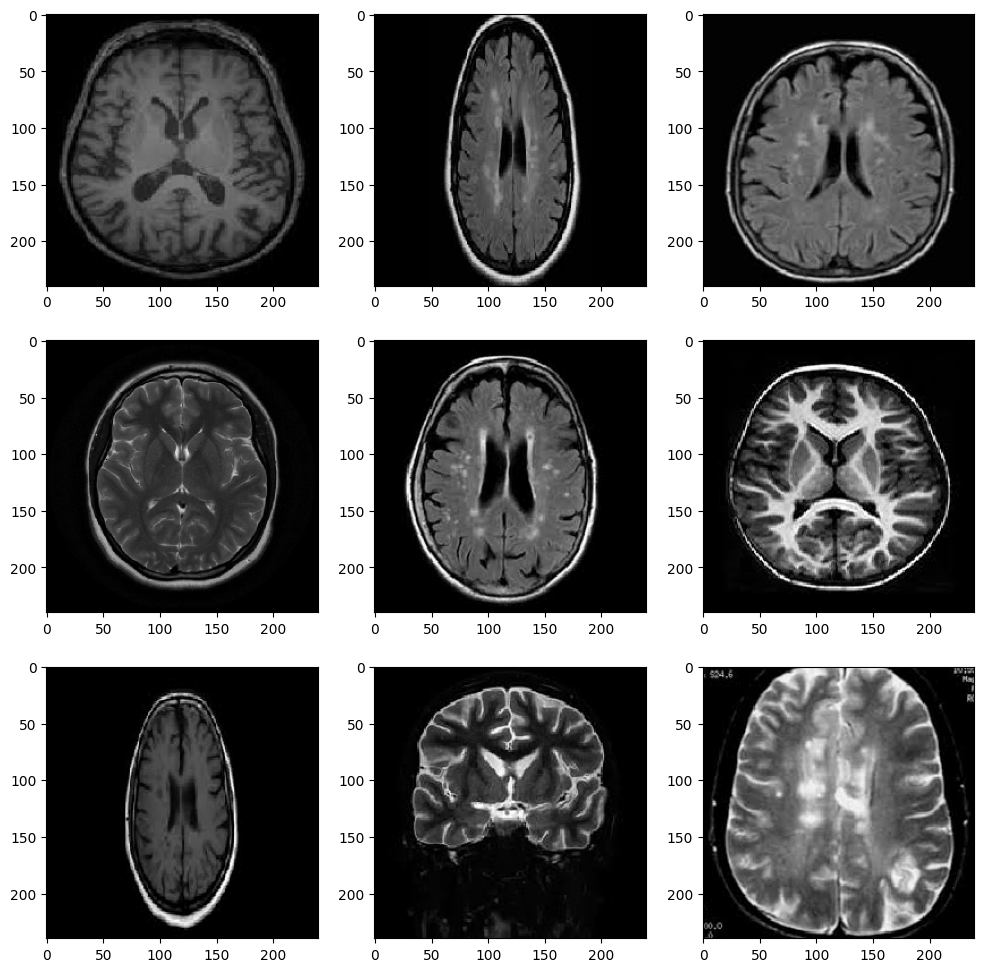

In [12]:
plot_state("no")

## Modeling using CNN

In [13]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 119, 119, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 64)                4

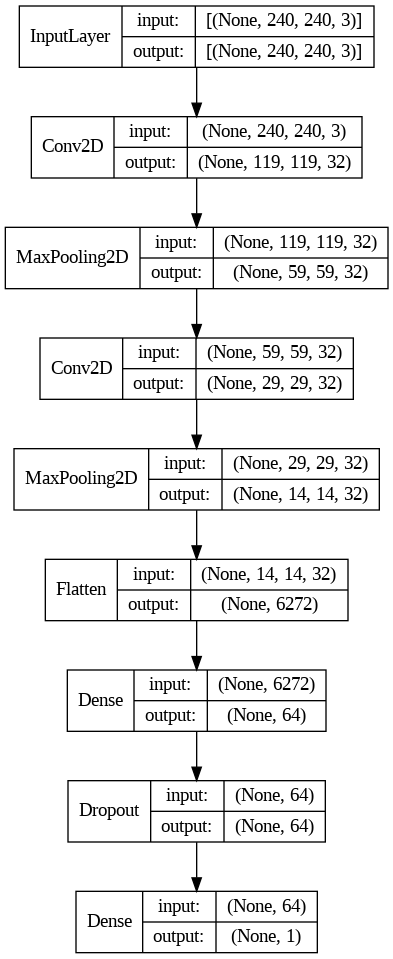

In [15]:
plot_model(model, show_shapes=True, show_layer_names=False)

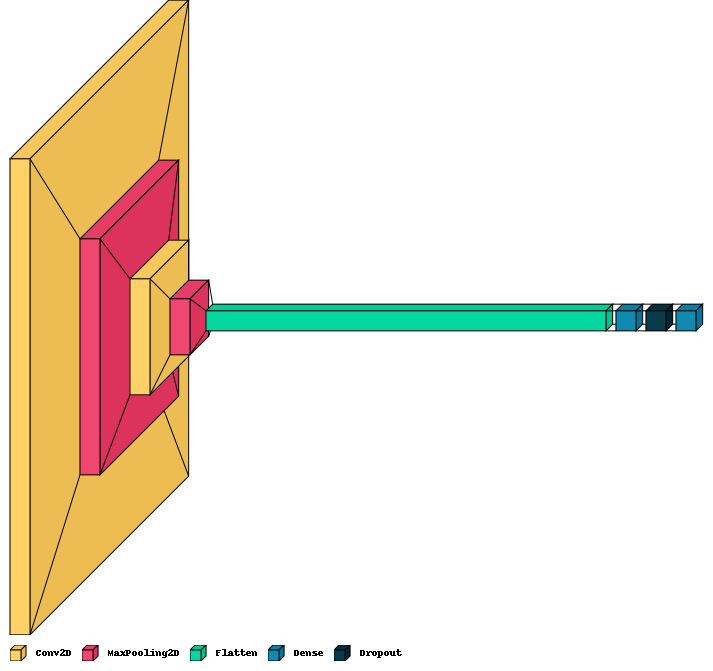

In [16]:
visualkeras.layered_view(model, legend=True)

In [17]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.294871794871795, 1: 0.8145161290322581}

In [18]:
history = model.fit(x_train,y_train,epochs = 100, class_weight=class_weights, validation_data=(x_test, y_test),verbose=1)

Epoch 1/100
7/7 [==============================] - 5s 546ms/step - loss: 23.3028 - accuracy: 0.4851 - val_loss: 6.2298 - val_accuracy: 0.3922
Epoch 2/100
7/7 [==============================] - 4s 623ms/step - loss: 5.9843 - accuracy: 0.3861 - val_loss: 6.8565 - val_accuracy: 0.3922
Epoch 3/100
7/7 [==============================] - 3s 365ms/step - loss: 5.6002 - accuracy: 0.3861 - val_loss: 5.1763 - val_accuracy: 0.3922
Epoch 4/100
7/7 [==============================] - 2s 327ms/step - loss: 5.0548 - accuracy: 0.3861 - val_loss: 4.8960 - val_accuracy: 0.3922
Epoch 5/100
7/7 [==============================] - 2s 356ms/step - loss: 4.8454 - accuracy: 0.3861 - val_loss: 4.7442 - val_accuracy: 0.3922
Epoch 6/100
7/7 [==============================] - 2s 362ms/step - loss: 4.6803 - accuracy: 0.3861 - val_loss: 4.5805 - val_accuracy: 0.3922
Epoch 7/100
7/7 [==============================] - 3s 474ms/step - loss: 4.5294 - accuracy: 0.3861 - val_loss: 4.4537 - val_accuracy: 0.3922
Epoch 8/100


## CNN model Evaluation

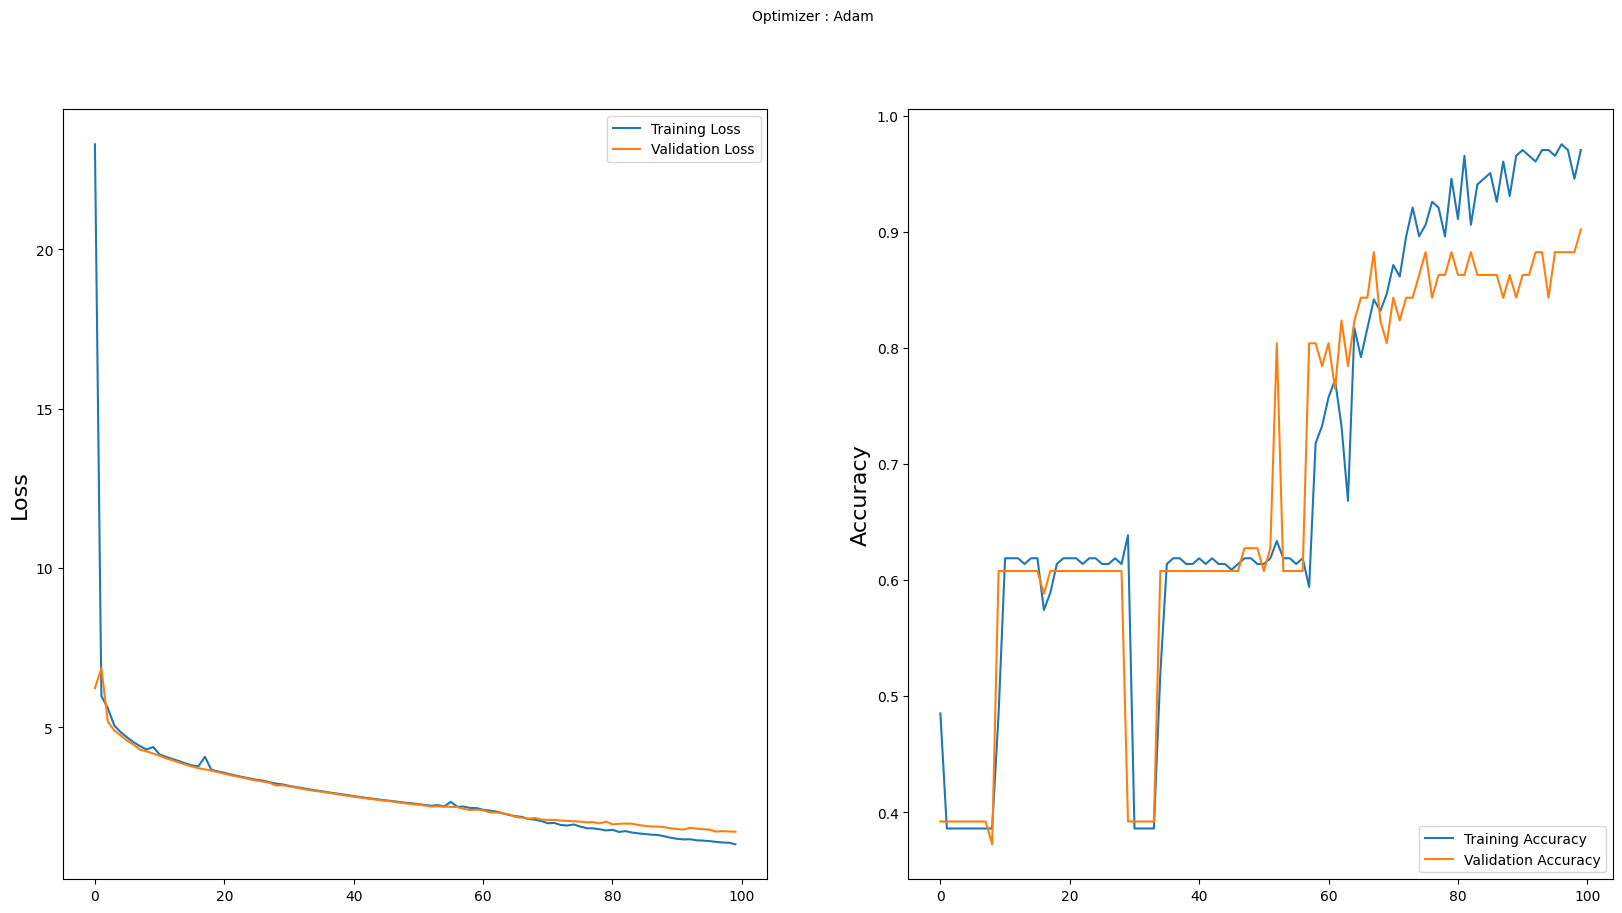

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [20]:
results = model.evaluate(x_test, y_test)
print('The current model achieved an accuracy of {}%!'.format(round(results[1]*100,2)))

2/2 [==============================] - 0s 126ms/step - loss: 1.7251 - accuracy: 0.9020
The current model achieved an accuracy of 90.2%!


In [21]:
# compute predictions
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 0s 110ms/step


In [22]:
def classification_performance(conf_matrix):
    accureacy=(conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
    recall=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])
    specificity=(conf_matrix[1][1])/(conf_matrix[0][1]+conf_matrix[1][1])
    precision=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
    F1_score=(2*precision*recall)/(precision+recall)
    GM=math.sqrt(recall*specificity)
    FPR=1-specificity
    return accureacy,recall,specificity,precision,F1_score,GM,FPR

In [23]:
k=10
kf = KFold(n_splits=k)
acc=np.empty(k, dtype = float)
recall=np.empty(k, dtype = float)
spec=np.empty(k, dtype = float)
precision=np.empty(k, dtype = float)
F1=np.empty(k, dtype = float)
GM=np.empty(k, dtype = float)
FPR=np.empty(k, dtype = float)
iter=0;
for train, test in kf.split(dataset):


    conf_matrix=confusion_matrix(y_test, y_pred)
    acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]=classification_performance(conf_matrix)
    print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]))
    iter=iter+1
print('------------AVERAGE-----------------')
print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc.mean(), recall.mean(), spec.mean(), precision.mean(), F1.mean(), GM.mean(), FPR.mean()))

Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
------------AVERAGE-----------------
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, 

In [24]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

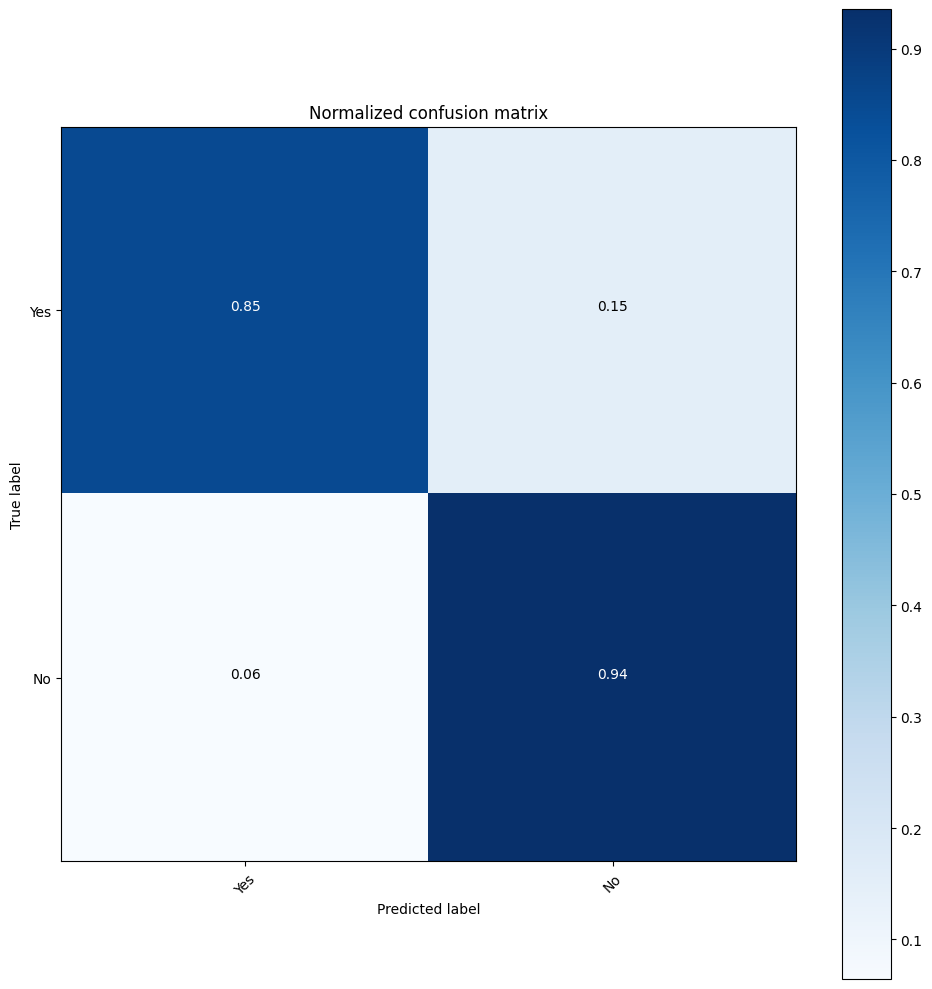

In [25]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Yes", "No"], title='Normalized confusion matrix')
plt.show()

## Modeling using Vision Transformers(ViT)

In [26]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 240  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Data augmentation

In [27]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Multi-layer perceptron

In [28]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [29]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 240 X 240
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 1200


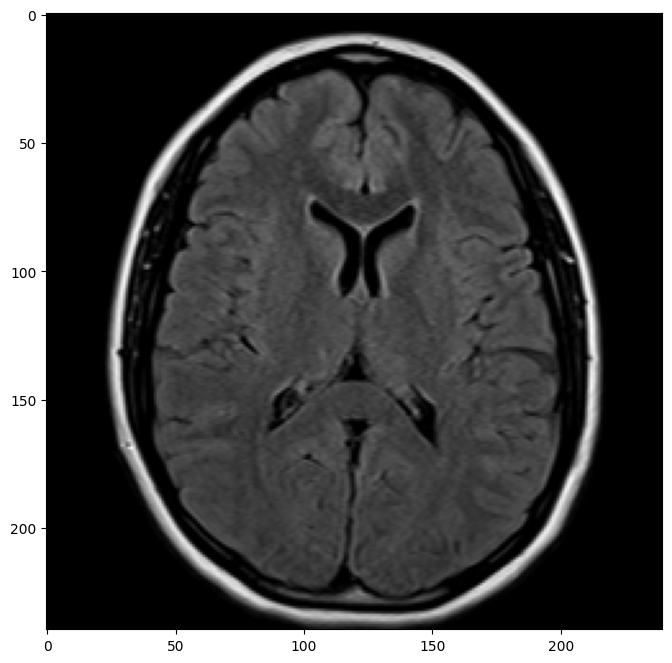

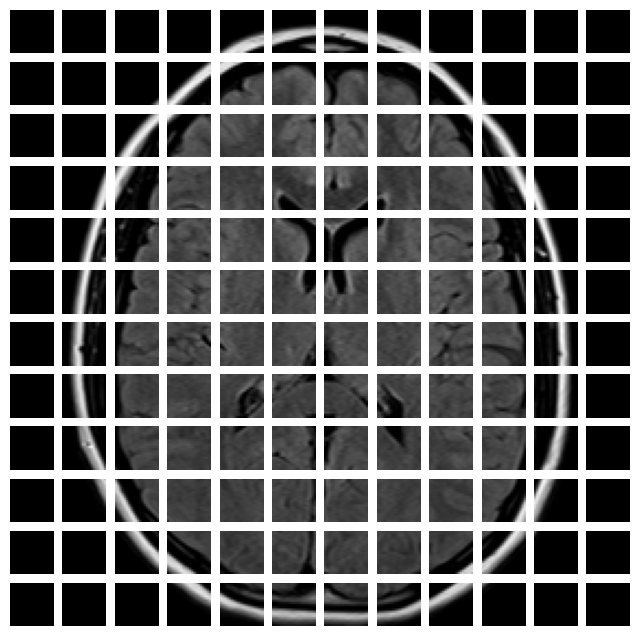

In [30]:
plt.figure(figsize=(8, 8))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


## Creating the patch encoder
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [31]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Building the ViT

The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [32]:
def create_vit_classifier():
    inputs = layers.Input(shape=(240, 240, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [33]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [34]:
vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 42s 42s/step - loss: 1.8423 - accuracy: 0.4158 - top-5-accuracy: 1.0000 - val_loss: 19.5069 - val_accuracy: 0.6078 - val_top-5-accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 26s 26s/step - loss: 18.3921 - accuracy: 0.6139 - top-5-accuracy: 1.0000 - val_loss: 3.1309 - val_accuracy: 0.5294 - val_top-5-accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 23s 23s/step - loss: 2.6826 - accuracy: 0.5941 - top-5-accuracy: 1.0000 - val_loss: 3.6474 - val_accuracy: 0.6078 - val_top-5-accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 23s 23s/step - loss: 4.5242 - accuracy: 0.6139 - top-5-accuracy: 1.0000 - val_loss: 0.5769 - val_accuracy: 0.6863 - val_top-5-accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 21s 21s/step - loss: 0.8175 - accuracy: 0.6485 - top-5-accuracy: 1.0000 - val_loss: 1.6650 - val_accuracy: 0.4118 - val_top-5-accuracy: 1.0000
Epoch 6/100
1/1 [===========

In [35]:
# compute predictions
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 0s 105ms/step


In [36]:
def classification_performance(conf_matrix):
    accureacy=(conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
    recall=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])
    specificity=(conf_matrix[1][1])/(conf_matrix[0][1]+conf_matrix[1][1])
    precision=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
    F1_score=(2*precision*recall)/(precision+recall)
    GM=math.sqrt(recall*specificity)
    FPR=1-specificity
    return accureacy,recall,specificity,precision,F1_score,GM,FPR

In [37]:
k=10
kf = KFold(n_splits=k)
acc=np.empty(k, dtype = float)
recall=np.empty(k, dtype = float)
spec=np.empty(k, dtype = float)
precision=np.empty(k, dtype = float)
F1=np.empty(k, dtype = float)
GM=np.empty(k, dtype = float)
FPR=np.empty(k, dtype = float)
iter=0;
for train, test in kf.split(dataset):


    conf_matrix=confusion_matrix(y_test, y_pred)
    acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]=classification_performance(conf_matrix)
    print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]))
    iter=iter+1
print('------------AVERAGE-----------------')
print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc.mean(), recall.mean(), spec.mean(), precision.mean(), F1.mean(), GM.mean(), FPR.mean()))

Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, F1=0.87, GM=0.90, FPR=0.09
------------AVERAGE-----------------
Accuracy: 0.90, Recall=0.89, specificity=0.91, precision=0.85, 

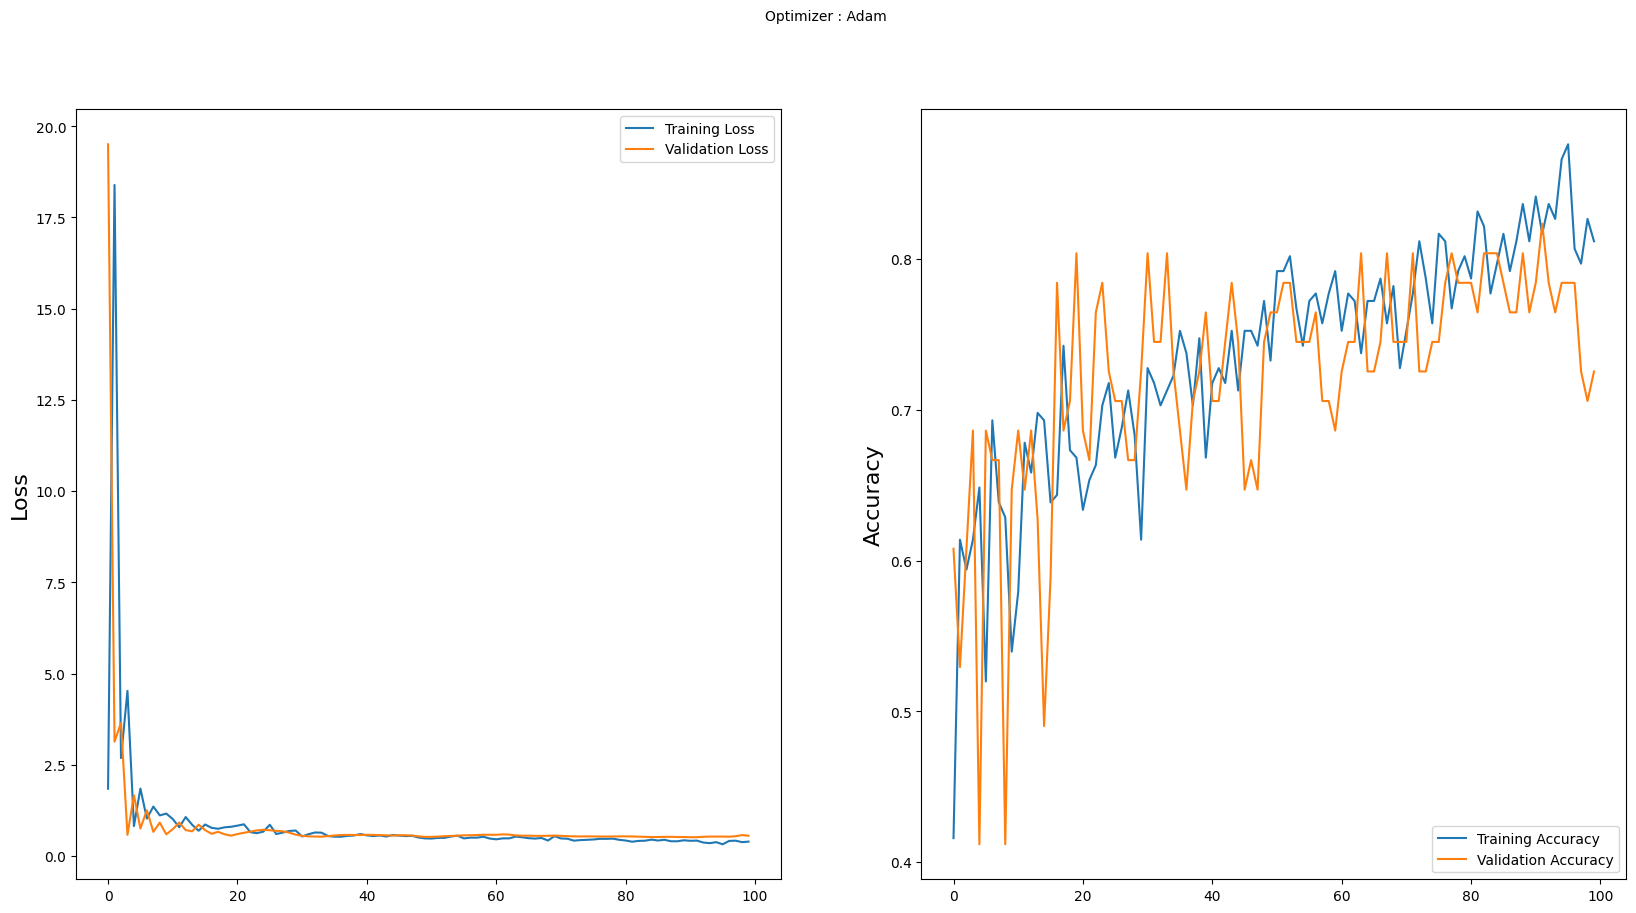

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [39]:
# compute predictions
vit_predictions = vit_classifier.predict(x_test)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

2/2 [==============================] - 4s 441ms/step


<Figure size 640x480 with 0 Axes>

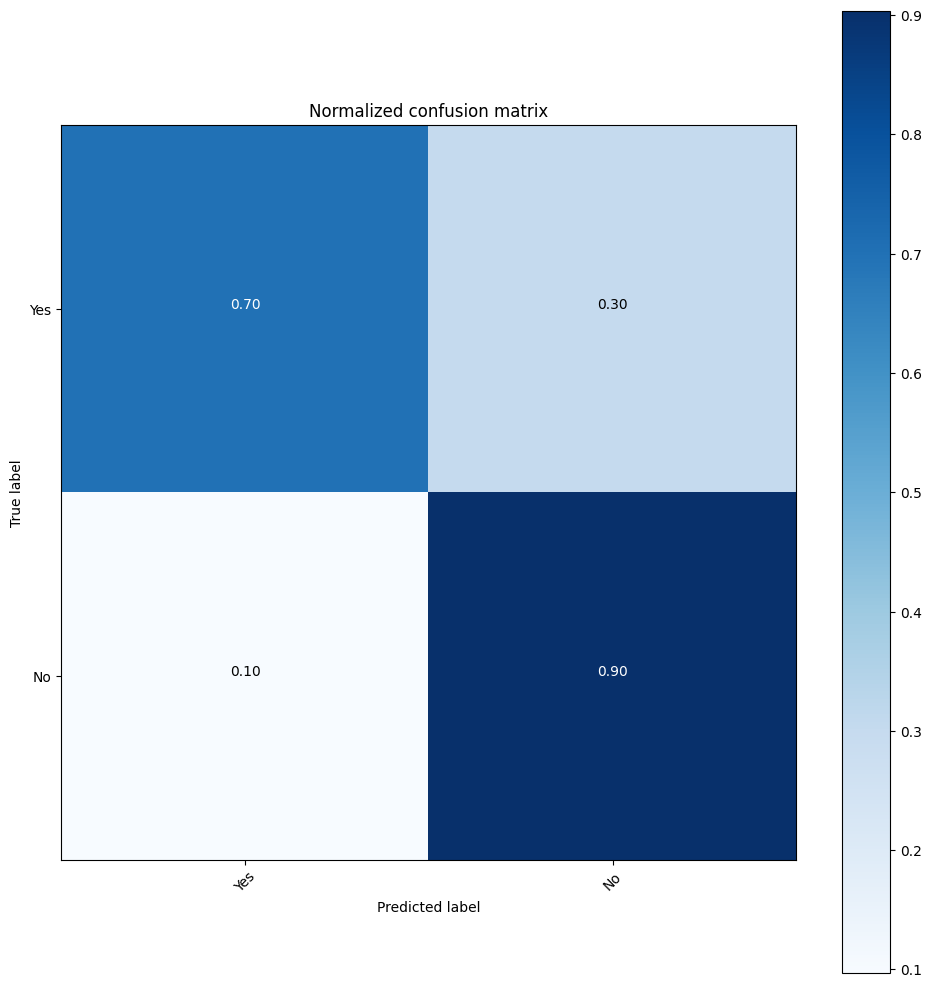

In [40]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, vit_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Yes", "No"], title='Normalized confusion matrix')
plt.show()

**Building the DeepViT**

In [41]:
pip install keras-models


In [42]:
pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.8 MB/s eta 0:00:00


In [43]:
import tensorflow as tf
from tensorflow import einsum
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn

from einops import rearrange, repeat
from einops.layers.tensorflow import Rearrange

class PreNorm(Layer):
    def _init_(self, fn):
        super(PreNorm, self)._init_()

        self.norm = nn.LayerNormalization()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(self.norm(x), training=training)

class MLP(Layer):
    def _init_(self, dim, hidden_dim, dropout=0.0):
        super(MLP, self)._init_()
        def GELU():
            def gelu(x, approximate=False):
                if approximate:
                    coeff = tf.cast(0.044715, x.dtype)
                    return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
                else:
                    return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

            return nn.Activation(gelu)

        self.net = [
            nn.Dense(units=hidden_dim),
            GELU(),
            nn.Dropout(rate=dropout),
            nn.Dense(units=dim),
            nn.Dropout(rate=dropout)
        ]
        self.net = Sequential(self.net)

    def call(self, x, training=True):
        return self.net(x, training=training)

class Attention(Layer):
    def _init_(self, dim, heads=8, dim_head=64, dropout=0.0):
        super(Attention, self)._init_()
        inner_dim = dim_head * heads

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax()
        self.to_qkv = nn.Dense(units=inner_dim * 3, use_bias=False)

        self.reattn_weights = tf.Variable(initial_value=tf.random.normal([heads, heads]))

        self.reattn_norm = [
            Rearrange('b h i j -> b i j h'),
            nn.LayerNormalization(),
            Rearrange('b i j h -> b h i j')
        ]

        self.to_out = [
            nn.Dense(units=dim),
            nn.Dropout(rate=dropout)
        ]

        self.reattn_norm = Sequential(self.reattn_norm)
        self.to_out = Sequential(self.to_out)

    def call(self, x, training=True):
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        # attention
        dots = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2])) * self.scale
        attn = self.attend(dots)

        # re-attention
        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out
        x = tf.matmul(attn, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.to_out(x, training=training)

        return x

class Transformer(Layer):
    def _init_(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super(Transformer, self)._init_()

        self.layers = []

        for _ in range(depth):
            self.layers.append([
                PreNorm(Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(MLP(dim, mlp_dim, dropout=dropout))
            ])

    def call(self, x, training=True):
        for attn, mlp in self.layers:
            x = attn(x, training=training) + x
            x = mlp(x, training=training) + x

        return x

class DeepViT(Model):
    def _init_(self, image_size=256, patch_size=32, num_classes=1000, dim=1020, depth=6, heads=16, mlp_dim=2048,
                 pool='cls', dim_head=64, dropout=0.0, emb_dropout=0.0):
        super(DeepViT, self)._init_()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.patch_embedding = Sequential([
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Dense(units=dim)
        ], name='patch_embedding')

        self.pos_embedding = tf.Variable(initial_value=tf.random.normal([1, num_patches + 1, dim]))
        self.cls_token = tf.Variable(initial_value=tf.random.normal([1, 1, dim]))
        self.dropout = nn.Dropout(rate=emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool

        self.mlp_head = Sequential([
            nn.LayerNormalization(),
            nn.Dense(units=num_classes)
        ], name='mlp_head')

    def call(self, img, training=True, **kwargs):
        x = self.patch_embedding(img)
        b, n, d = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x, training=training)

        x = self.transformer(x, training=training)

        if self.pool == 'mean':
            x = tf.reduce_mean(x, axis=1)
        else:
            x = x[:, 0]

        x = self.mlp_head(x)

        return x



# v = DeepViT(
#     image_size = 256,
#     patch_size = 32,
#     num_classes = 1000,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1
# )

# img = tf.random.normal(shape=[1, 256, 256, 3])
# preds = v(img) # (1, 1000)

In [44]:
def run_experiment(x):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    x.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),##
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    # model.load_weights(checkpoint_filepath)    #model=x
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test) #model=x
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [45]:
vit_classifier = DeepViT()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.3328 - accuracy: 0.9851 - val_loss: 1.7342 - val_accuracy: 0.8824
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 1.3258 - accuracy: 0.9851 - val_loss: 1.7431 - val_accuracy: 0.8824
Epoch 3/100
1/1 [==============================] - 7s 7s/step - loss: 1.3323 - accuracy: 0.9752 - val_loss: 1.7498 - val_accuracy: 0.8824
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 1.3345 - accuracy: 0.9703 - val_loss: 1.7541 - val_accuracy: 0.8824
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 1.3277 - accuracy: 0.9653 - val_loss: 1.7554 - val_accuracy: 0.8824
Epoch 6/100
1/1 [==============================] - 7s 7s/step - loss: 1.3198 - accuracy: 0.9752 - val_loss: 1.7549 - val_accuracy: 0.8824
Epoch 7/100
1/1 [==============================] - 5s 5s/step - loss: 1.3116 - accuracy: 0.9802 - val_loss: 1.7509 - val_accuracy: 0.8824
Epoch 8/100
1/1 [=================

In [46]:
# compute predictions
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 0s 104ms/step


In [47]:
def classification_performance(conf_matrix):
    accureacy=(conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
    recall=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])
    specificity=(conf_matrix[1][1])/(conf_matrix[0][1]+conf_matrix[1][1])
    precision=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
    F1_score=(2*precision*recall)/(precision+recall)
    GM=math.sqrt(recall*specificity)
    FPR=1-specificity
    return accureacy,recall,specificity,precision,F1_score,GM,FPR

In [48]:
k=10
kf = KFold(n_splits=k)
acc=np.empty(k, dtype = float)
recall=np.empty(k, dtype = float)
spec=np.empty(k, dtype = float)
precision=np.empty(k, dtype = float)
F1=np.empty(k, dtype = float)
GM=np.empty(k, dtype = float)
FPR=np.empty(k, dtype = float)
iter=0;
for train, test in kf.split(dataset):


    conf_matrix=confusion_matrix(y_test, y_pred)
    acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]=classification_performance(conf_matrix)
    print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]))
    iter=iter+1
print('------------AVERAGE-----------------')
print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc.mean(), recall.mean(), spec.mean(), precision.mean(), F1.mean(), GM.mean(), FPR.mean()))

Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
------------AVERAGE-----------------
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, 

*Building the MobileViT*

In [49]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn

from einops import rearrange
from einops.layers.tensorflow import Reduce


def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))


class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)


class Swish(Layer):
    def __init__(self):
        super(Swish, self).__init__()

    def call(self, x, training=True):
        x = tf.keras.activations.swish(x)
        return x


class Conv_NxN_BN(Layer):
    def __init__(self, dim, kernel_size=1, stride=1):
        super(Conv_NxN_BN, self).__init__()

        self.layers = Sequential([
            nn.Conv2D(filters=dim, kernel_size=kernel_size, strides=stride, padding='SAME', use_bias=False),
            nn.BatchNormalization(momentum=0.9, epsilon=1e-5),
            Swish()
        ])

    def call(self, x, training=True):
        x = self.layers(x, training=training)
        return x


class PreNorm(Layer):
    def __init__(self, fn):
        super(PreNorm, self).__init__()

        self.norm = nn.LayerNormalization()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(self.norm(x), training=training)


class MLP(Layer):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super(MLP, self).__init__()

        self.net = Sequential([
            nn.Dense(units=hidden_dim),
            Swish(),
            nn.Dropout(rate=dropout),
            nn.Dense(units=dim),
            nn.Dropout(rate=dropout)
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)


class Attention(Layer):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super(Attention, self).__init__()

        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax()
        self.to_qkv = nn.Dense(units=inner_dim * 3, use_bias=False)

        self.to_out = Sequential([
            nn.Dense(units=dim),
            nn.Dropout(rate=dropout)
        ])

    def call(self, x, training=True):
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)

        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h=self.heads), qkv)

        dots = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2])) * self.scale
        attn = self.attend(dots)
        out = tf.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        out = self.to_out(out, training=training)

        return out


class Transformer(Layer):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super(Transformer, self).__init__()

        self.layers = []

        for _ in range(depth):
            self.layers.append([
                PreNorm(Attention(dim, heads, dim_head, dropout)),
                PreNorm(MLP(dim, mlp_dim, dropout))
            ])

    def call(self, x, training=True):
        for attn, ff in self.layers:
            x = attn(x, training=training) + x
            x = ff(x, training=training) + x

        return x


class MV2Block(Layer):
    def __init__(self, dim_in, dim_out, stride=1, expansion=4):
        super(MV2Block, self).__init__()

        assert stride in [1, 2]

        hidden_dim = int(dim_in * expansion)
        self.use_res_connect = stride == 1 and dim_in == dim_out

        if expansion == 1:
            self.conv = Sequential([
                # dw
                nn.Conv2D(filters=hidden_dim, kernel_size=3, strides=stride, padding='SAME', groups=hidden_dim,
                          use_bias=False),
                nn.BatchNormalization(momentum=0.9, epsilon=1e-5),
                Swish(),
                # pw-linear
                nn.Conv2D(filters=dim_out, kernel_size=1, strides=1, use_bias=False),
                nn.BatchNormalization(momentum=0.9, epsilon=1e-5)
            ])
        else:
            self.conv = Sequential([
                # pw
                nn.Conv2D(filters=hidden_dim, kernel_size=1, strides=1, use_bias=False),
                nn.BatchNormalization(momentum=0.9, epsilon=1e-5),
                Swish(),
                # dw
                nn.Conv2D(filters=hidden_dim, kernel_size=3, strides=stride, padding='SAME', groups=hidden_dim,
                          use_bias=False),
                nn.BatchNormalization(momentum=0.9, epsilon=1e-5),
                Swish(),
                # pw-linear
                nn.Conv2D(filters=dim_out, kernel_size=1, strides=1, use_bias=False),
                nn.BatchNormalization(momentum=0.9, epsilon=1e-5)
            ])

    def call(self, x, training=True):
        out = self.conv(x, training=training)
        if self.use_res_connect:
            out = out + x
        return out


class MobileViTBlock(Layer):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.0):
        super(MobileViTBlock, self).__init__()

        self.ph, self.pw = patch_size

        self.conv1 = Conv_NxN_BN(channel, kernel_size=kernel_size, stride=1)
        self.conv2 = Conv_NxN_BN(dim, kernel_size=1, stride=1)

        self.transformer = Transformer(dim=dim, depth=depth, heads=4, dim_head=8, mlp_dim=mlp_dim, dropout=dropout)

        self.conv3 = Conv_NxN_BN(channel, kernel_size=1, stride=1)
        self.conv4 = Conv_NxN_BN(channel, kernel_size=kernel_size, stride=1)

    def call(self, x, training=True):
        y = tf.identity(x)

        # Local representations
        x = self.conv1(x, training=training)
        x = self.conv2(x, training=training)

        # Global representations
        _, h, w, c = x.shape
        x = rearrange(x, 'b (h ph) (w pw) d -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x, training=training)
        x = rearrange(x, 'b (ph pw) (h w) d -> b (h ph) (w pw) d', h=h // self.ph, w=w // self.pw, ph=self.ph,
                      pw=self.pw)

        # Fusion
        x = self.conv3(x, training=training)
        x = tf.concat([x, y], axis=-1)
        x = self.conv4(x, training=training)

        return x


class MobileViT(Model):
    def __init__(self,
                 image_size=(256, 256),
                 dims=[96, 120, 144],
                 channels=[16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],
                 num_classes=1000,
                 expansion=4,
                 kernel_size=3,
                 patch_size=(2, 2),
                 depths=(2, 4, 3)
                 ):
        super(MobileViT, self).__init__()
        assert len(dims) == 3, 'dims must be a tuple of 3'
        assert len(depths) == 3, 'depths must be a tuple of 3'

        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        init_dim, *_, last_dim = channels

        self.conv1 = Conv_NxN_BN(init_dim, kernel_size=3, stride=2)

        self.stem = Sequential()
        self.stem.add(MV2Block(channels[0], channels[1], stride=1, expansion=expansion))
        self.stem.add(MV2Block(channels[1], channels[2], stride=2, expansion=expansion))
        self.stem.add(MV2Block(channels[2], channels[3], stride=1, expansion=expansion))
        self.stem.add(MV2Block(channels[2], channels[3], stride=1, expansion=expansion))

        self.trunk = []
        self.trunk.append([
            MV2Block(channels[3], channels[4], stride=2, expansion=expansion),
            MobileViTBlock(dims[0], depths[0], channels[5], kernel_size, patch_size, mlp_dim=int(dims[0] * 2))
        ])

        self.trunk.append([
            MV2Block(channels[5], channels[6], stride=2, expansion=expansion),
            MobileViTBlock(dims[1], depths[1], channels[7], kernel_size, patch_size, mlp_dim=int(dims[1] * 4))
        ])

        self.trunk.append([
            MV2Block(channels[7], channels[8], stride=2, expansion=expansion),
            MobileViTBlock(dims[2], depths[2], channels[9], kernel_size, patch_size, mlp_dim=int(dims[2] * 4))
        ])

        self.to_logits = Sequential([
            Conv_NxN_BN(last_dim, kernel_size=1, stride=1),
            Reduce('b h w c -> b c', 'mean'),
            nn.Dense(units=num_classes, use_bias=False)
        ])

    def call(self, x, training=True, **kwargs):
        x = self.conv1(x, training=training)

        x = self.stem(x, training=training)

        for conv, attn in self.trunk:
            x = conv(x, training=training)
            x = attn(x, training=training)

        x = self.to_logits(x, training=training)

        return x

""" Usage
v = MobileViT(
    image_size=(256, 256),
    dims=[96, 120, 144],
    channels=[16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],
    num_classes=1000
)

img = tf.random.normal(shape=[1, 256, 256, 3])
preds = v(img)  # (1, 1000)
"""

' Usage\nv = MobileViT(\n    image_size=(256, 256),\n    dims=[96, 120, 144],\n    channels=[16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],\n    num_classes=1000\n)\n\nimg = tf.random.normal(shape=[1, 256, 256, 3])\npreds = v(img)  # (1, 1000)\n'

In [50]:
def run_experiment(x):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    x.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    # x.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = x.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [51]:
vit_classifier = MobileViT()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.1000 - accuracy: 0.9950 - val_loss: 1.5528 - val_accuracy: 0.8824
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 1.0820 - accuracy: 0.9950 - val_loss: 1.5499 - val_accuracy: 0.8824
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 1.0784 - accuracy: 1.0000 - val_loss: 1.5518 - val_accuracy: 0.8824
Epoch 4/100
1/1 [==============================] - 7s 7s/step - loss: 1.0680 - accuracy: 1.0000 - val_loss: 1.5554 - val_accuracy: 0.8824
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 1.0765 - accuracy: 0.9950 - val_loss: 1.5574 - val_accuracy: 0.8824
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 1.0603 - accuracy: 0.9950 - val_loss: 1.5526 - val_accuracy: 0.8824
Epoch 7/100
1/1 [==============================] - 8s 8s/step - loss: 1.0742 - accuracy: 0.9802 - val_loss: 1.5465 - val_accuracy: 0.8824
Epoch 8/100
1/1 [=================

In [52]:
# compute predictions
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 0s 58ms/step


In [53]:
def classification_performance(conf_matrix):
    accureacy=(conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
    recall=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])
    specificity=(conf_matrix[1][1])/(conf_matrix[0][1]+conf_matrix[1][1])
    precision=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
    F1_score=(2*precision*recall)/(precision+recall)
    GM=math.sqrt(recall*specificity)
    FPR=1-specificity
    return accureacy,recall,specificity,precision,F1_score,GM,FPR

In [54]:
k=10
kf = KFold(n_splits=k)
acc=np.empty(k, dtype = float)
recall=np.empty(k, dtype = float)
spec=np.empty(k, dtype = float)
precision=np.empty(k, dtype = float)
F1=np.empty(k, dtype = float)
GM=np.empty(k, dtype = float)
FPR=np.empty(k, dtype = float)
iter=0;
for train, test in kf.split(dataset):


    conf_matrix=confusion_matrix(y_test, y_pred)
    acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]=classification_performance(conf_matrix)
    print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]))
    iter=iter+1
print('------------AVERAGE-----------------')
print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc.mean(), recall.mean(), spec.mean(), precision.mean(), F1.mean(), GM.mean(), FPR.mean()))

Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
------------AVERAGE-----------------
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, 

*Building the CaitViT*

In [55]:
import tensorflow as tf
from tensorflow import einsum
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn

from einops import rearrange, repeat
from einops.layers.tensorflow import Rearrange

from random import randrange
import numpy as np

def exists(val):
    return val is not None

def dropout_layers(layers, dropout):
    if dropout == 0:
        return layers

    num_layers = len(layers)

    to_drop = np.random.uniform(low=0.0, high=1.0, size=[num_layers]) < dropout

    # make sure at least one layer makes it
    if all(to_drop):
        rand_index = randrange(num_layers)
        to_drop[rand_index] = False

    layers = [layer for (layer, drop) in zip(layers, to_drop) if not drop]
    return layers

class LayerScale(Layer):
    def _init_(self, dim, fn, depth):
        super(LayerScale, self)._init_()
        if depth <= 18: # epsilon detailed in section 2 of paper
            init_eps = 0.1
        elif depth > 18 and depth <= 24:
            init_eps = 1e-5
        else:
            init_eps = 1e-6

        scale = tf.fill(dims=[1, 1, dim], value=init_eps)
        self.scale = tf.Variable(scale)
        self.fn = fn

    def call(self, x, training=True, **kwargs):
        return self.fn(x, training=training, **kwargs) * self.scale

class PreNorm(Layer):
    def _init_(self, fn):
        super(PreNorm, self)._init_()

        self.norm = nn.LayerNormalization()
        self.fn = fn

    def call(self, x, training=True, **kwargs):
        return self.fn(self.norm(x), training=training, **kwargs)

class MLP(Layer):
    def _init_(self, dim, hidden_dim, dropout=0.0):
        super(MLP, self)._init_()
        def GELU():
            def gelu(x, approximate=False):
                if approximate:
                    coeff = tf.cast(0.044715, x.dtype)
                    return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
                else:
                    return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

            return nn.Activation(gelu)

        self.net = [
            nn.Dense(units=hidden_dim),
            GELU(),
            nn.Dropout(rate=dropout),
            nn.Dense(units=dim),
            nn.Dropout(rate=dropout)
        ]
        self.net = Sequential(self.net)

    def call(self, x, training=True):
        return self.net(x, training=training)

class Attention(Layer):
    def _init_(self, dim, heads=8, dim_head=64, dropout=0.0):
        super(Attention, self)._init_()
        inner_dim = dim_head * heads

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax()
        self.to_q = nn.Dense(units=inner_dim, use_bias=False)
        self.to_kv = nn.Dense(units=inner_dim * 2, use_bias=False)

        self.mix_heads_pre_attn = tf.Variable(initial_value=tf.random.normal([heads, heads]))
        self.mix_heads_post_attn = tf.Variable(initial_value=tf.random.normal([heads, heads]))

        self.to_out = [
            nn.Dense(units=dim),
            nn.Dropout(rate=dropout)
        ]

        self.to_out = Sequential(self.to_out)

    def call(self, x, context=None, training=True):

        if not exists(context):
            context = x
        else:
            context = tf.concat([x, context], axis=1)

        q = self.to_q(x)
        kv = self.to_kv(context)
        k, v = tf.split(kv, num_or_size_splits=2, axis=-1)
        qkv = (q, k, v)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        dots = einsum('b h i j, h g -> b g i j', dots, self.mix_heads_pre_attn)  # talking heads, pre-softmax
        attn = self.attend(dots)
        attn = einsum('b h i j, h g -> b g i j', attn, self.mix_heads_post_attn)  # talking heads, post-softmax

        x = tf.matmul(attn, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.to_out(x, training=training)

        return x

class Transformer(Layer):
    def _init_(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0, layer_dropout=0.0):
        super(Transformer, self)._init_()

        self.layers = []
        self.layer_dropout = layer_dropout

        for ind in range(depth):
            self.layers.append([
                LayerScale(dim, PreNorm(Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)), depth=ind+1),
                LayerScale(dim, PreNorm(MLP(dim, mlp_dim, dropout=dropout)), depth=ind+1)
            ])

    def call(self, x, context=None, training=True):
        layers = dropout_layers(self.layers, dropout=self.layer_dropout)

        for attn, mlp in layers:
            x = attn(x, context=context, training=training) + x
            x = mlp(x, training=training) + x

        return x

class CaiT(Model):
    def _init_(self, image_size=256, patch_size=32, num_classes=1000, dim=1024, depth=12, cls_depth=2, heads=16, mlp_dim=2048,
                 dim_head=64, dropout=0.0, emb_dropout=0.0, layer_dropout=0.0):
        super(CaiT, self)._init_()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2

        self.patch_embedding = Sequential([
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Dense(units=dim)
        ], name='patch_embedding')

        self.pos_embedding = tf.Variable(initial_value=tf.random.normal([1, num_patches, dim]))
        self.cls_token = tf.Variable(initial_value=tf.random.normal([1, 1, dim]))
        self.dropout = nn.Dropout(rate=emb_dropout)

        self.patch_transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout, layer_dropout)
        self.cls_transformer = Transformer(dim, cls_depth, heads, dim_head, mlp_dim, dropout, layer_dropout)

        self.mlp_head = Sequential([
            nn.LayerNormalization(),
            nn.Dense(units=num_classes)
        ], name='mlp_head')

    def call(self, img, training=True, **kwargs):
        x = self.patch_embedding(img)
        b, n, d = x.shape

        x += self.pos_embedding[:, :n]
        x = self.dropout(x, training=training)

        x = self.patch_transformer(x, training=training)

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = self.cls_transformer(cls_tokens, context=x, training=training)

        x = self.mlp_head(x[:, 0])

        return x

""" Usage
v = CaiT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 12,             # depth of transformer for patch to patch attention only
    cls_depth = 2,          # depth of cross attention of CLS tokens to patch
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1,
    layer_dropout = 0.05    # randomly dropout 5% of the layers
)

img = tf.random.normal(shape=[1, 256, 256, 3])
preds = v(img) # (1, 1000)
"""

' Usage\nv = CaiT(\n    image_size = 256,\n    patch_size = 32,\n    num_classes = 1000,\n    dim = 1024,\n    depth = 12,             # depth of transformer for patch to patch attention only\n    cls_depth = 2,          # depth of cross attention of CLS tokens to patch\n    heads = 16,\n    mlp_dim = 2048,\n    dropout = 0.1,\n    emb_dropout = 0.1,\n    layer_dropout = 0.05    # randomly dropout 5% of the layers\n)\n\nimg = tf.random.normal(shape=[1, 256, 256, 3])\npreds = v(img) # (1, 1000)\n'

In [56]:
def run_experiment(x):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    x.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    # x.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = x.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [57]:
vit_classifier = CaiT()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.9210 - accuracy: 0.9950 - val_loss: 1.4465 - val_accuracy: 0.8627
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.9157 - accuracy: 1.0000 - val_loss: 1.4486 - val_accuracy: 0.8627
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 0.9116 - accuracy: 1.0000 - val_loss: 1.4482 - val_accuracy: 0.8627
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 0.9193 - accuracy: 0.9950 - val_loss: 1.4442 - val_accuracy: 0.8627
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 0.9083 - accuracy: 1.0000 - val_loss: 1.4377 - val_accuracy: 0.8627
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.9103 - accuracy: 0.9901 - val_loss: 1.4287 - val_accuracy: 0.8627
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.9083 - accuracy: 1.0000 - val_loss: 1.4241 - val_accuracy: 0.8627
Epoch 8/100
1/1 [=================

In [58]:
# compute predictions
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 0s 76ms/step


In [59]:
def classification_performance(conf_matrix):
    accureacy=(conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
    recall=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])
    specificity=(conf_matrix[1][1])/(conf_matrix[0][1]+conf_matrix[1][1])
    precision=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
    F1_score=(2*precision*recall)/(precision+recall)
    GM=math.sqrt(recall*specificity)
    FPR=1-specificity
    return accureacy,recall,specificity,precision,F1_score,GM,FPR

In [60]:
k=10
kf = KFold(n_splits=k)
acc=np.empty(k, dtype = float)
recall=np.empty(k, dtype = float)
spec=np.empty(k, dtype = float)
precision=np.empty(k, dtype = float)
F1=np.empty(k, dtype = float)
GM=np.empty(k, dtype = float)
FPR=np.empty(k, dtype = float)
iter=0;
for train, test in kf.split(dataset):


    conf_matrix=confusion_matrix(y_test, y_pred)
    acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]=classification_performance(conf_matrix)
    print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]))
    iter=iter+1
print('------------AVERAGE-----------------')
print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc.mean(), recall.mean(), spec.mean(), precision.mean(), F1.mean(), GM.mean(), FPR.mean()))

Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
------------AVERAGE-----------------
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, 

*Building the LeViT*

In [61]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn

from tensorflow import einsum
from einops import rearrange

from math import ceil

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cast_tuple(val, l = 3):
    val = val if isinstance(val, tuple) else (val,)
    return (*val, *((val[-1],) * max(l - len(val), 0)))

def always(val):
    return lambda *args, **kwargs: val

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class HardSwish(Layer):
    def __init__(self):
        super(HardSwish, self).__init__()

    def call(self, x, training=True):
        x = x * tf.nn.relu6(x + 3.0) / 6.0
        return x

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

class MLP(Layer):
    def __init__(self, dim, mult, dropout=0.0):
        super(MLP, self).__init__()

        self.net = [
            nn.Conv2D(filters=dim * mult, kernel_size=1, strides=1),
            HardSwish(),
            nn.Dropout(rate=dropout),
            nn.Conv2D(filters=dim, kernel_size=1, strides=1),
            nn.Dropout(rate=dropout)
        ]
        self.net = Sequential(self.net)

    def call(self, x, training=True):
        return self.net(x, training=training)

class Attention(Layer):
    def __init__(self, dim, fmap_size, heads=8, dim_key=32, dim_value=64, dropout=0.0, dim_out=None, downsample=False):
        super(Attention, self).__init__()
        inner_dim_key = dim_key * heads
        inner_dim_value = dim_value * heads
        dim_out = default(dim_out, dim)

        self.heads = heads
        self.scale = dim_key ** -0.5

        self.to_q = Sequential([
            nn.Conv2D(filters=inner_dim_key, kernel_size=1, strides=(2 if downsample else 1), use_bias=False),
            nn.BatchNormalization(momentum=0.9, epsilon=1e-05),
        ])

        self.to_k = Sequential([
            nn.Conv2D(filters=inner_dim_key, kernel_size=1, strides=1, use_bias=False),
            nn.BatchNormalization(momentum=0.9, epsilon=1e-05),
        ])

        self.to_v = Sequential([
            nn.Conv2D(filters=inner_dim_value, kernel_size=1, strides=1, use_bias=False),
            nn.BatchNormalization(momentum=0.9, epsilon=1e-05),
        ])

        self.attend = nn.Softmax()

        out_batch_norm = nn.BatchNormalization(momentum=0.9, epsilon=1e-05, gamma_initializer='zeros')

        self.to_out = Sequential([
            GELU(),
            nn.Conv2D(filters=dim_out, kernel_size=1, strides=1),
            out_batch_norm,
            nn.Dropout(rate=dropout)
        ])

        # positional bias
        self.pos_bias = nn.Embedding(input_dim=fmap_size * fmap_size, output_dim=heads)
        q_range = tf.range(0, fmap_size, delta=(2 if downsample else 1))
        k_range = tf.range(fmap_size)

        q_pos = tf.stack(tf.meshgrid(q_range, q_range, indexing='ij'), axis=-1)
        k_pos = tf.stack(tf.meshgrid(k_range, k_range, indexing='ij'), axis=-1)

        q_pos, k_pos = map(lambda t: rearrange(t, 'i j c -> (i j) c'), (q_pos, k_pos))
        rel_pos = tf.abs((q_pos[:, None, ...] - k_pos[None, :, ...]))

        x_rel, y_rel = tf.unstack(rel_pos, axis=-1)
        self.pos_indices = (x_rel * fmap_size) + y_rel

    def apply_pos_bias(self, fmap):
        bias = self.pos_bias(self.pos_indices)
        bias = rearrange(bias, 'i j h -> () h i j')
        return fmap + (bias / self.scale)

    def call(self, x, training=True):
        b, height, width, n = x.shape
        q = self.to_q(x)

        h = self.heads
        y = q.shape[1] # height

        qkv = (q, self.to_k(x), self.to_v(x))
        q, k, v = map(lambda t: rearrange(t, 'b ... (h d) -> b h (...) d', h=h), qkv)

        # i,j = height*width
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        dots = self.apply_pos_bias(dots)

        attn = self.attend(dots)

        x = einsum('b h i j, b h j d -> b h i d', attn, v)
        x = rearrange(x, 'b h (x y) d -> b x y (h d)', h=h, y=y)
        x = self.to_out(x, training=training)

        return x

class Transformer(Layer):
    def __init__(self, dim, fmap_size, depth, heads, dim_key, dim_value, mlp_mult=2, dropout=0.0, dim_out=None, downsample=False):
        super(Transformer, self).__init__()

        dim_out = default(dim_out, dim)
        self.attn_residual = (not downsample) and dim == dim_out
        self.layers = []

        for _ in range(depth):
            self.layers.append([
                Attention(dim, fmap_size=fmap_size, heads=heads, dim_key=dim_key, dim_value=dim_value,
                          dropout=dropout, downsample=downsample, dim_out=dim_out),
                MLP(dim_out, mlp_mult, dropout=dropout)
            ])

    def call(self, x, training=True):
        for attn, mlp in self.layers:
            attn_res = (x if self.attn_residual else 0)
            x = attn(x, training=training) + attn_res
            x = mlp(x, training=training) + x

        return x

class LeViT(Model):
    def __init__(self,
                 image_size=224,
                 num_classes=1000,
                 dim=(256, 384, 512),
                 depth=4,
                 heads=(4, 6, 8),
                 mlp_mult=2,
                 stages=3,
                 dim_key=32,
                 dim_value=64,
                 dropout=0.0,
                 num_distill_classes=None
                 ):
        super(LeViT, self).__init__()

        dims = cast_tuple(dim, stages)
        depths = cast_tuple(depth, stages)
        layer_heads = cast_tuple(heads, stages)

        assert all(map(lambda t: len(t) == stages, (dims, depths, layer_heads))), \
            'dimensions, depths, and heads must be a tuple that is less than the designated number of stages'

        self.conv_embedding = Sequential([
            nn.Conv2D(filters=32, kernel_size=3, strides=2, padding='SAME'),
            nn.Conv2D(filters=64, kernel_size=3, strides=2, padding='SAME'),
            nn.Conv2D(filters=128, kernel_size=3, strides=2, padding='SAME'),
            nn.Conv2D(filters=dims[0], kernel_size=3, strides=2, padding='SAME')
        ])

        fmap_size = image_size // (2 ** 4)
        self.backbone = Sequential()

        for ind, dim, depth, heads in zip(range(stages), dims, depths, layer_heads):
            is_last = ind == (stages - 1)
            self.backbone.add(Transformer(dim, fmap_size, depth, heads, dim_key, dim_value, mlp_mult, dropout))

            if not is_last:
                next_dim = dims[ind + 1]
                self.backbone.add(Transformer(dim, fmap_size, 1, heads * 2, dim_key, dim_value, dim_out=next_dim, downsample=True))
                fmap_size = ceil(fmap_size / 2)

        self.pool = Sequential([
            nn.GlobalAvgPool2D()
        ])

        self.distill_head = nn.Dense(units=num_distill_classes) if exists(num_distill_classes) else always(None)
        self.mlp_head = nn.Dense(units=num_classes)


    def call(self, img, training=True, **kwargs):
        x = self.conv_embedding(img)

        x = self.backbone(x)

        x = self.pool(x)
        out = self.mlp_head(x)
        distill = self.distill_head(x)

        if exists(distill):
            return out, distill

        return out

""" Usage
levit = LeViT(
    image_size = 224,
    num_classes = 1000,
    stages = 3,             # number of stages
    dim = (256, 384, 512),  # dimensions at each stage
    depth = 4,              # transformer of depth 4 at each stage
    heads = (4, 6, 8),      # heads at each stage
    mlp_mult = 2,
    dropout = 0.1
)

img = tf.random.normal(shape=[1, 224, 224, 3])
preds = levit(img) # (1, 1000)
"""

' Usage\nlevit = LeViT(\n    image_size = 224,\n    num_classes = 1000,\n    stages = 3,             # number of stages\n    dim = (256, 384, 512),  # dimensions at each stage\n    depth = 4,              # transformer of depth 4 at each stage\n    heads = (4, 6, 8),      # heads at each stage\n    mlp_mult = 2,\n    dropout = 0.1\n)\n\nimg = tf.random.normal(shape=[1, 224, 224, 3])\npreds = levit(img) # (1, 1000)\n'

In [62]:
def run_experiment(x):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    x.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    # x.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = x.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [63]:
vit_classifier = LeViT()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7932 - accuracy: 1.0000 - val_loss: 1.3735 - val_accuracy: 0.8627
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.7937 - accuracy: 0.9950 - val_loss: 1.3801 - val_accuracy: 0.8627
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 0.7898 - accuracy: 0.9950 - val_loss: 1.3737 - val_accuracy: 0.8627
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 0.7903 - accuracy: 1.0000 - val_loss: 1.3534 - val_accuracy: 0.8627
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 0.7848 - accuracy: 0.9950 - val_loss: 1.3365 - val_accuracy: 0.8627
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 0.7866 - accuracy: 1.0000 - val_loss: 1.3221 - val_accuracy: 0.8627
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 0.7852 - accuracy: 1.0000 - val_loss: 1.3180 - val_accuracy: 0.8824
Epoch 8/100
1/1 [=================

In [64]:
# compute predictions
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 0s 50ms/step


In [65]:
def classification_performance(conf_matrix):
    accureacy=(conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
    recall=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])
    specificity=(conf_matrix[1][1])/(conf_matrix[0][1]+conf_matrix[1][1])
    precision=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
    F1_score=(2*precision*recall)/(precision+recall)
    GM=math.sqrt(recall*specificity)
    FPR=1-specificity
    return accureacy,recall,specificity,precision,F1_score,GM,FPR

In [66]:
k=10
kf = KFold(n_splits=k)
acc=np.empty(k, dtype = float)
recall=np.empty(k, dtype = float)
spec=np.empty(k, dtype = float)
precision=np.empty(k, dtype = float)
F1=np.empty(k, dtype = float)
GM=np.empty(k, dtype = float)
FPR=np.empty(k, dtype = float)
iter=0;
for train, test in kf.split(dataset):


    conf_matrix=confusion_matrix(y_test, y_pred)
    acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]=classification_performance(conf_matrix)
    print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]))
    iter=iter+1
print('------------AVERAGE-----------------')
print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc.mean(), recall.mean(), spec.mean(), precision.mean(), F1.mean(), GM.mean(), FPR.mean()))

Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, F1=0.82, GM=0.86, FPR=0.12
------------AVERAGE-----------------
Accuracy: 0.86, Recall=0.84, specificity=0.88, precision=0.80, 

*Building the RegionViT*

In [67]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn
from tensorflow import einsum

from einops import rearrange
from einops.layers.tensorflow import Rearrange, Reduce

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cast_tuple(val, length = 1):
    return val if isinstance(val, tuple) else ((val,) * length)

def divisible_by(val, d):
    return (val % d) == 0

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)

class Downsample(Layer):
    def __init__(self, dim):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2D(filters=dim, kernel_size=3, strides=2, padding='SAME')

    def call(self, x, training=True):
        x = self.conv(x)
        return x

class PEG(Layer):
    def __init__(self, dim, kernel_size=3):
        super(PEG, self).__init__()
        self.proj = nn.Conv2D(filters=dim, kernel_size=kernel_size, strides=1, padding='SAME', groups=dim)

    def call(self, x, training=True):
        x = self.proj(x) + x
        return x


class MLP(Layer):
    def __init__(self, dim, mult=4, dropout=0.0):
        super(MLP, self).__init__()

        self.net = Sequential([
            nn.LayerNormalization(),
            nn.Dense(units=dim * mult),
            GELU(),
            nn.Dropout(rate=dropout),
            nn.Dense(units=dim)
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)

class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head=32, dropout=0.0):
        super(Attention, self).__init__()

        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNormalization()
        self.attend = nn.Softmax()
        self.to_qkv = nn.Dense(units=inner_dim * 3, use_bias=False)

        self.to_out = nn.Dense(units=dim)

    def call(self, x, rel_pos_bias=None, training=True):
        h = self.heads

        # prenorm
        x = self.norm(x)
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        q = q * self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)

        # add relative positional bias for local tokens
        if exists(rel_pos_bias):
            sim = sim + rel_pos_bias
        attn = self.attend(sim)

        # merge heads

        x = einsum('b h i j, b h j d -> b h i d', attn, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.to_out(x)

        return x

class R2LTransformer(Layer):
    def __init__(self, dim, window_size, depth=4, heads=4, dim_head=32, attn_dropout=0.0, ff_dropout=0.0):
        super(R2LTransformer, self).__init__()

        self.layers = []

        self.window_size = window_size
        rel_positions = 2 * window_size - 1
        self.local_rel_pos_bias = nn.Embedding(rel_positions ** 2, heads)

        for _ in range(depth):
            self.layers.append([
                Attention(dim, heads=heads, dim_head=dim_head, dropout=attn_dropout),
                MLP(dim, dropout=ff_dropout)
            ])


    def call(self, local_tokens, region_tokens=None, training=True):
        lh, lw = local_tokens.shape[1:3]
        rh, rw = region_tokens.shape[1:3]
        window_size_h, window_size_w = lh // rh, lw // rw

        local_tokens = rearrange(local_tokens, 'b h w c -> b (h w) c')
        region_tokens = rearrange(region_tokens, 'b h w c -> b (h w) c')

        # calculate local relative positional bias
        h_range = tf.range(window_size_h)
        w_range = tf.range(window_size_w)

        grid_x, grid_y = tf.meshgrid(h_range, w_range, indexing='ij')
        grid = tf.stack([grid_x, grid_y])
        grid = rearrange(grid, 'c h w -> c (h w)')
        grid = (grid[:, :, None] - grid[:, None, :]) + (self.window_size - 1)

        bias_indices = tf.reduce_sum((grid * tf.convert_to_tensor([1, self.window_size * 2 - 1])[:, None, None]), axis=0)
        rel_pos_bias = self.local_rel_pos_bias(bias_indices)
        rel_pos_bias = rearrange(rel_pos_bias, 'i j h -> () h i j')
        rel_pos_bias = tf.pad(rel_pos_bias, paddings=[[0, 0], [0, 0], [1, 0], [1, 0]])

        # go through r2l transformer layers
        for attn, ff in self.layers:
            region_tokens = attn(region_tokens) + region_tokens

            # concat region tokens to local tokens

            local_tokens = rearrange(local_tokens, 'b (h w) d -> b h w d', h=lh)
            local_tokens = rearrange(local_tokens, 'b (h p1) (w p2) d -> (b h w) (p1 p2) d', p1=window_size_h, p2=window_size_w)
            region_tokens = rearrange(region_tokens, 'b n d -> (b n) () d')

            # do self attention on local tokens, along with its regional token
            region_and_local_tokens = tf.concat([region_tokens, local_tokens], axis=1)
            region_and_local_tokens = attn(region_and_local_tokens, rel_pos_bias=rel_pos_bias) + region_and_local_tokens

            # feedforward
            region_and_local_tokens = ff(region_and_local_tokens, training=training) + region_and_local_tokens

            # split back local and regional tokens
            region_tokens, local_tokens = region_and_local_tokens[:, :1], region_and_local_tokens[:, 1:]
            local_tokens = rearrange(local_tokens, '(b h w) (p1 p2) d -> b (h p1 w p2) d', h=lh // window_size_h, w=lw // window_size_w, p1=window_size_h)
            region_tokens = rearrange(region_tokens, '(b n) () d -> b n d', n=rh * rw)

        local_tokens = rearrange(local_tokens, 'b (h w) c -> b h w c', h=lh, w=lw)
        region_tokens = rearrange(region_tokens, 'b (h w) c -> b h w c', h=rh, w=rw)

        return local_tokens, region_tokens

class RegionViT(Model):
    def __init__(self,
                 dim=(64, 128, 256, 512),
                 depth=(2, 2, 8, 2),
                 window_size=7,
                 num_classes=1000,
                 tokenize_local_3_conv=False,
                 local_patch_size=4,
                 use_peg=False,
                 attn_dropout=0.0,
                 ff_dropout=0.0,
                 ):
        super(RegionViT, self).__init__()
        dim = cast_tuple(dim, 4)
        depth = cast_tuple(depth, 4)
        assert len(dim) == 4, 'dim needs to be a single value or a tuple of length 4'
        assert len(depth) == 4, 'depth needs to be a single value or a tuple of length 4'

        self.local_patch_size = local_patch_size

        region_patch_size = local_patch_size * window_size
        self.region_patch_size = local_patch_size * window_size

        init_dim, *_, last_dim = dim

        # local and region encoders
        if tokenize_local_3_conv:
            self.local_encoder = Sequential([
                nn.Conv2D(filters=init_dim, kernel_size=3, strides=2, padding='SAME'),
                nn.LayerNormalization(),
                GELU(),
                nn.Conv2D(filters=init_dim, kernel_size=3, strides=2, padding='SAME'),
                nn.LayerNormalization(),
                GELU(),
                nn.Conv2D(filters=init_dim, kernel_size=3, strides=1, padding='SAME')
            ])
        else:
            self.local_encoder = nn.Conv2D(filters=init_dim, kernel_size=8, strides=4, padding='SAME')

        self.region_encoder = Sequential([
            Rearrange('b (h p1) (w p2) c -> b h w (c p1 p2) ', p1=region_patch_size, p2=region_patch_size),
            nn.Conv2D(filters=init_dim, kernel_size=1, strides=1)
        ])

        # layers
        self.region_layers = []

        for ind, dim, num_layers in zip(range(4), dim, depth):
            not_first = ind != 0
            need_downsample = not_first
            need_peg = not_first and use_peg

            self.region_layers.append([
                Downsample(dim) if need_downsample else Identity(),
                PEG(dim) if need_peg else Identity(),
                R2LTransformer(dim, depth=num_layers, window_size=window_size, attn_dropout=attn_dropout, ff_dropout=ff_dropout)
            ])

        # final logits
        self.to_logits = Sequential([
            Reduce('b h w c -> b c', 'mean'),
            nn.LayerNormalization(),
            nn.Dense(units=num_classes)
        ])

    def call(self, x, training=True, **kwargs):
        _, h, w, _ = x.shape
        assert divisible_by(h, self.region_patch_size) and divisible_by(w, self.region_patch_size), 'height and width must be divisible by region patch size'
        assert divisible_by(h, self.local_patch_size) and divisible_by(w, self.local_patch_size), 'height and width must be divisible by local patch size'

        local_tokens = self.local_encoder(x)
        region_tokens = self.region_encoder(x)

        for down, peg, transformer in self.region_layers:
            local_tokens, region_tokens = down(local_tokens), down(region_tokens)
            local_tokens = peg(local_tokens)
            local_tokens, region_tokens = transformer(local_tokens, region_tokens, training=training)

        x = self.to_logits(region_tokens)
        return x

""" Usage
v = RegionViT(
    dim = (64, 128, 256, 512),      # tuple of size 4, indicating dimension at each stage
    depth = (2, 2, 8, 2),           # depth of the region to local transformer at each stage
    window_size = 7,                # window size, which should be either 7 or 14
    num_classes = 1000,             # number of output classes
    tokenize_local_3_conv = False,  # whether to use a 3 layer convolution to encode the local tokens from the image. the paper uses this for the smaller models, but uses only 1 conv (set to False) for the larger models
    use_peg = False,                # whether to use positional generating module. they used this for object detection for a boost in performance
)

img = tf.random.normal(shape=[1, 224, 224, 3])
preds = v(img) # (1, 1000)
"""

' Usage\nv = RegionViT(\n    dim = (64, 128, 256, 512),      # tuple of size 4, indicating dimension at each stage\n    depth = (2, 2, 8, 2),           # depth of the region to local transformer at each stage\n    window_size = 7,                # window size, which should be either 7 or 14\n    num_classes = 1000,             # number of output classes\n    tokenize_local_3_conv = False,  # whether to use a 3 layer convolution to encode the local tokens from the image. the paper uses this for the smaller models, but uses only 1 conv (set to False) for the larger models\n    use_peg = False,                # whether to use positional generating module. they used this for object detection for a boost in performance\n)\n\nimg = tf.random.normal(shape=[1, 224, 224, 3])\npreds = v(img) # (1, 1000)\n'

In [68]:
def run_experiment(x):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    x.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    # x.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = x.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [69]:
vit_classifier = CaiT()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6954 - accuracy: 0.9901 - val_loss: 1.2679 - val_accuracy: 0.8627
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.6815 - accuracy: 1.0000 - val_loss: 1.2563 - val_accuracy: 0.8627
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 0.6864 - accuracy: 1.0000 - val_loss: 1.2507 - val_accuracy: 0.8627
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 0.6787 - accuracy: 1.0000 - val_loss: 1.2506 - val_accuracy: 0.8627
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 0.6793 - accuracy: 0.9950 - val_loss: 1.2504 - val_accuracy: 0.8627
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 0.6745 - accuracy: 1.0000 - val_loss: 1.2517 - val_accuracy: 0.8627
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.6761 - accuracy: 1.0000 - val_loss: 1.2541 - val_accuracy: 0.8627
Epoch 8/100
1/1 [=================

In [70]:
# compute predictions
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

2/2 [==============================] - 0s 53ms/step


In [71]:
def classification_performance(conf_matrix):
    accureacy=(conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
    recall=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])
    specificity=(conf_matrix[1][1])/(conf_matrix[0][1]+conf_matrix[1][1])
    precision=(conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
    F1_score=(2*precision*recall)/(precision+recall)
    GM=math.sqrt(recall*specificity)
    FPR=1-specificity
    return accureacy,recall,specificity,precision,F1_score,GM,FPR



In [72]:
k=10
kf = KFold(n_splits=k)
acc=np.empty(k, dtype = float)
recall=np.empty(k, dtype = float)
spec=np.empty(k, dtype = float)
precision=np.empty(k, dtype = float)
F1=np.empty(k, dtype = float)
GM=np.empty(k, dtype = float)
FPR=np.empty(k, dtype = float)
iter=0;
for train, test in kf.split(dataset):


    conf_matrix=confusion_matrix(y_test, y_pred)
    acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]=classification_performance(conf_matrix)
    print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc[iter], recall[iter], spec[iter], precision[iter], F1[iter], GM[iter], FPR[iter]))
    iter=iter+1
print('------------AVERAGE-----------------')
print("Accuracy: %0.2f, Recall=%0.2f, specificity=%0.2f, precision=%0.2f, F1=%0.2f, GM=%0.2f, FPR=%0.2f" % (acc.mean(), recall.mean(), spec.mean(), precision.mean(), F1.mean(), GM.mean(), FPR.mean()))

Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, F1=0.84, GM=0.88, FPR=0.12
------------AVERAGE-----------------
Accuracy: 0.88, Recall=0.89, specificity=0.88, precision=0.80, 